# BLAES Unit Quality Metrics

This notebook contains code for calculating and visualizing group-level unit quality metrics (i.e., Mean FR, ISI, FF, CV, PR, WF Mean SNR, WF Peak SNR).

---

> *Contact: Justin Campbell (justin.campbell@hsc.utah.edu)*  
> *Version: 05/07/2024*

## 1. Import Libraries

In [1]:
# Libraries
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from spiketools.measures.spikes import compute_firing_rate, compute_isis, compute_fano_factor, compute_cv, compute_presence_ratio
from spiketools.measures.conversions import convert_times_to_train
from IPython.display import clear_output

# Display params
%matplotlib inline
%config InlineBackend.figure_format='retina'
# %config InlineBackend.figure_format='svg'

## 2. Load Data
Spike times are stored in `Events.csv` and the waveforms are stored in `Waveforms.csv`.

In [2]:
export = True

In [3]:
# Define paths
results_path = '/Users/justincampbell/Library/CloudStorage/GoogleDrive-u0815766@gcloud.utah.edu/My Drive/Research Projects/BLAESUnits/Results/'

# Parameters
fs = 30000

# Combine all Events.csv files
event_files = glob.glob(results_path + '*/Events.csv')
events = []
for file in event_files:
    df = pd.read_csv(file, index_col = 0)
    df['pID'] = file.split('/')[-2]
    events.append(df)
events = pd.concat(events)
events['Time'] = events['TimeStamps'] / fs
events['Label'] = events['Channel'] + '-' + events['Unit'].astype(str)

# Load statsDF
stats_df = pd.read_csv(os.path.join(results_path, 'Group', 'SpikeStats.csv'), index_col = 0)
stats_df['Lead'] = [x[:-3] for x in stats_df['Unit'].values[:]]

## 3. Calculate Quality Metrics
1. Units Counts (per wire)
2. Firing Rate
3. Interspike Intervals
4. Coefficient of Variation
5. Fano Factor
6. Presence Ratio
7. Waveform Peak SNR
8. Waveform Mean SNR

In [4]:
def qualityMetrics(unit_events):
    '''
    Compute quality metrics for a single unit.
    
    Inputs:
    - unit_events: DataFrame with unit events
    
    Outputs:
    - metric_df: DataFrame with quality metrics
    '''
    
    # Get waveforms associated with unit
    pID = unit_events['pID'].values[0]
    label = unit_events['Label'].values[0]
    wfs = pd.read_csv(os.path.join(results_path, pID, 'Waveforms.csv'), index_col = 0)
    event_idxs = unit_events.index
    unit_wfs = wfs.loc[event_idxs,:]
    
    # Get spike times (s) and binary spike train
    spike_times = unit_events['Time'].values
    spike_train = convert_times_to_train(spike_times, fs)

    # Mean Firing Rate (Hz)
    fr = compute_firing_rate(spike_times)

    # Interspike Intervals (ISI)
    isis = compute_isis(spike_times) # array
    isis_3ms = 100 * (len(isis[isis < 0.003]) / len(isis)) # ISIs < 3ms (%)

    # Fano Factor (FF)
    ff = compute_fano_factor(spike_train)

    # Coefficient of Variation (CV)
    cv = compute_cv(isis)

    # Presence Ratio (PR)
    pr = compute_presence_ratio(spike_times, bins = 1) # 1s bins
    pr = pr * 100 # convert to %

    # Waveform Mean SNR
    wf_mean = unit_wfs.mean(axis = 0)
    wf_sd = unit_wfs.std(axis = 0)
    wf_snr = np.abs(wf_mean / wf_sd).mean()

    # Waveform Peak SNR
    wf_peak = unit_wfs.mean(axis = 0).min()
    wf_peak_time = unit_wfs.mean(axis = 0).idxmin()
    wf_peak_sd = unit_wfs.std(axis = 0).loc[wf_peak_time]
    wf_peak_snr = np.abs(wf_peak / wf_peak_sd)

    # Isolation Distance
    
    # Create metrics dataframe
    metric_df = pd.DataFrame({'pID': pID, 
                            'Label': label,
                            'FR': fr, 
                            'ISIs': isis_3ms, 
                            'FF': ff, 
                            'CV': cv, 
                            'PR': pr,
                            'Peak SNR': wf_peak_snr,
                            'Mean SNR': wf_snr
                            }, index = [0])
    
    return metric_df

In [ ]:
# Compute metrics separately for each unit
metric_dfs = []
count = 0
for unit, df in events.groupby(['pID', 'Label']):
    metric_dfs.append(qualityMetrics(df))
    count += 1
    print('Processed %i/%i units' % (count, len(events.groupby(['pID', 'Label']))))
    clear_output(wait=True)
        
group_metrics = pd.concat(metric_dfs)
group_metrics = group_metrics.reset_index(drop = True)
group_metrics.to_csv(os.path.join(results_path, 'Group', 'UnitQualityMetrics.csv'))

In [8]:
# Get counts of units per lead
lead_counts = []
for pID in stats_df['pID'].unique():
    pID_df = stats_df[stats_df['pID'] == pID]
    for lead in pID_df['Lead'].unique():
        lead_df = pID_df[pID_df['Lead'] == lead]
        lead_counts.append(lead_df.shape[0])
        
lead_counts = pd.DataFrame(np.histogram(lead_counts, bins = np.arange(0, 13, 1))).T
lead_counts.columns = ['Count', 'Leads']
lead_counts = lead_counts.fillna(0)

# convert columns to int
lead_counts['Count'] = lead_counts['Count'].astype(int)
lead_counts['Leads'] = lead_counts['Leads'].astype(int)

## 4. Visualize Metrics

In [9]:
group_metrics = pd.read_csv(os.path.join(results_path, 'Group', 'UnitQualityMetrics.csv'), index_col = 0)

In [10]:
# Load existing (manually defined)
exclude_units = pd.read_csv('/Users/justincampbell/Library/CloudStorage/GoogleDrive-u0815766@gcloud.utah.edu/My Drive/Research Projects/BLAESUnits/UnitsToExclude.csv')

# remove rows from group_metrics that match the pID and Unit in exclude_units
for index, row in exclude_units.iterrows():
    group_metrics = group_metrics[~((group_metrics['pID'] == row['pID']) & (group_metrics['Label'] == row['Unit']))]

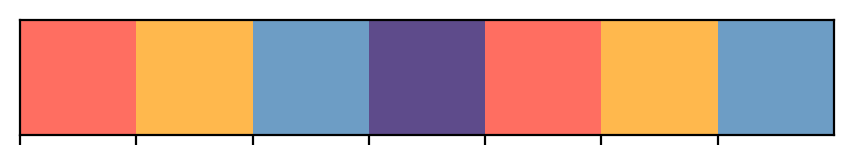

In [11]:
plotPal = ['#ff6e61', '#ffb84d', '#6d9dc5', '#5e4b8b', '#ff6e61', '#ffb84d', '#6d9dc5',]
sns.palplot(plotPal, 0.75)

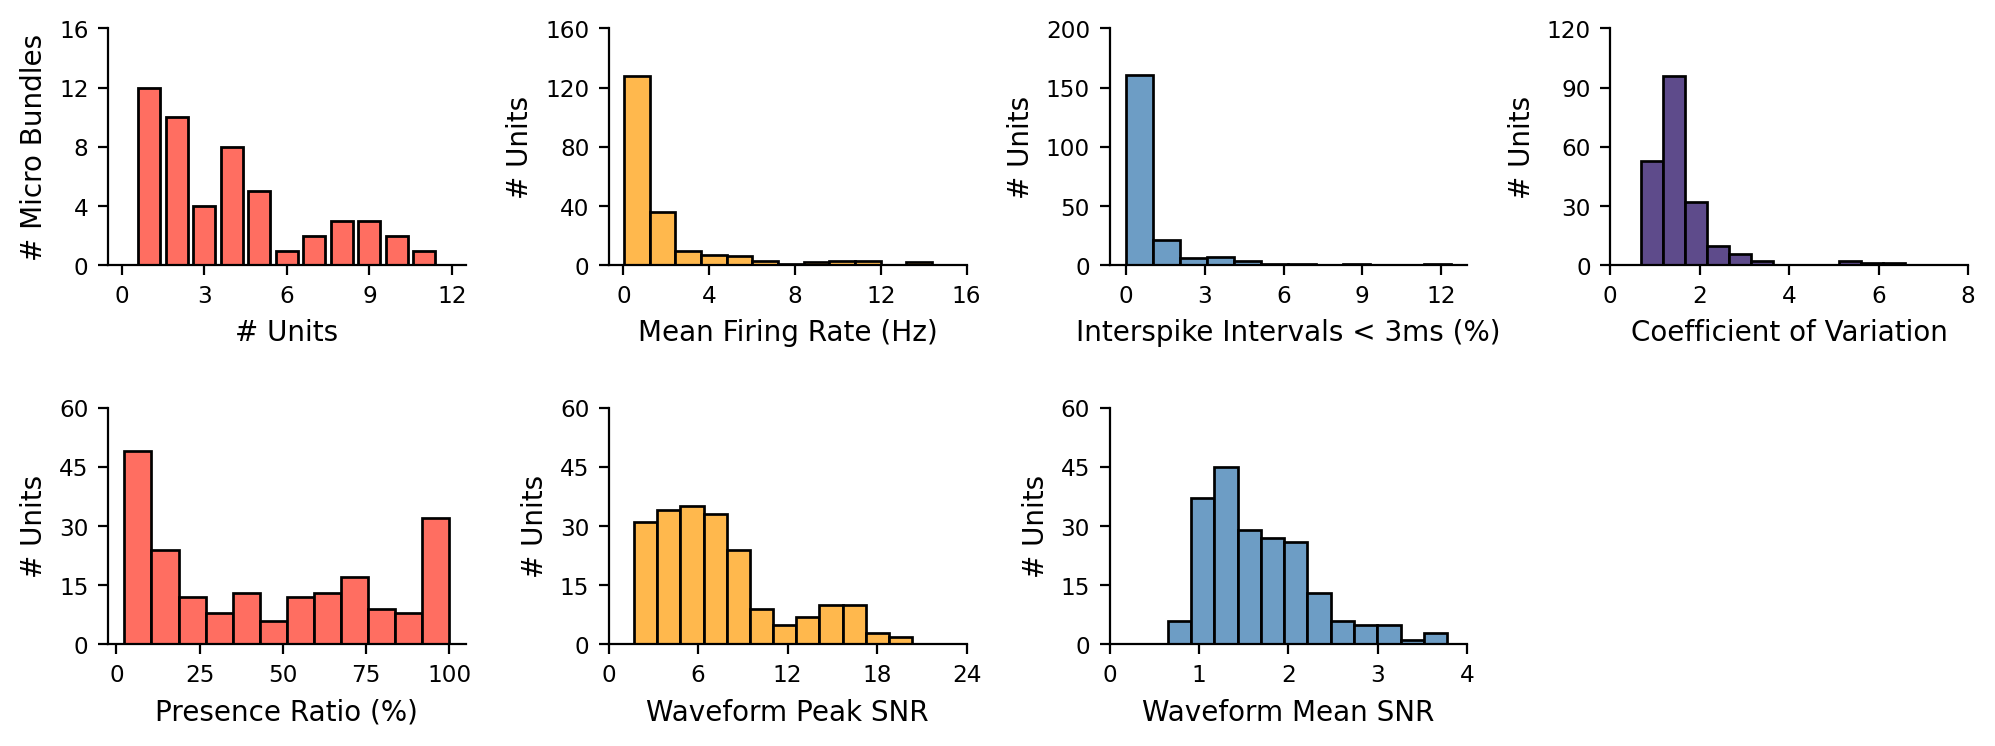

In [12]:
# Plot parameters
fig, axes = plt.subplots(2, 4, figsize=(12, 4))
fig.subplots_adjust(wspace=0.4, hspace=0.6)
fig.delaxes(axes[1, 3])
palette = plotPal
plt.rcParams['xtick.labelsize'] = 'small'
plt.rcParams['ytick.labelsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'

# Plot histograms
n_bins = 12
sns.barplot(data = lead_counts, x = 'Leads', y = 'Count', color = palette[0], ax = axes[0, 0], saturation = 1)
sns.histplot(data = group_metrics[group_metrics['FR'] < 16], x = 'FR', bins = n_bins, color = palette[1], ax = axes[0, 1], alpha = 1) # remove single outlier
sns.histplot(data = group_metrics, x = 'ISIs', bins = n_bins, color = palette[2], ax = axes[0, 2], alpha = 1)
sns.histplot(data = group_metrics, x = 'CV', bins = n_bins, color = palette[3], ax = axes[0, 3], alpha = 1)
sns.histplot(data = group_metrics, x = 'PR', bins = n_bins, color = palette[4], ax = axes[1, 0], alpha = 1)
sns.histplot(data = group_metrics, x = 'Peak SNR', bins = n_bins, color = palette[5], ax = axes[1, 1], alpha = 1)
sns.histplot(data = group_metrics, x = 'Mean SNR', bins = n_bins, color = palette[6], ax = axes[1, 2], alpha = 1)

# Figure labels
axes[0, 0].set_xlabel('# Units')
axes[0, 1].set_xlabel('Mean Firing Rate (Hz)')
axes[0, 2].set_xlabel('Interspike Intervals < 3ms (%)')
axes[0, 3].set_xlabel('Coefficient of Variation')
axes[1, 0].set_xlabel('Presence Ratio (%)')
axes[1, 1].set_xlabel('Waveform Peak SNR')
axes[1, 2].set_xlabel('Waveform Mean SNR')

# Set xticks
plt.setp(axes[0,0].patches, linewidth = 1, edgecolor = 'k')
axes[0, 0].set_xticks(np.arange(0, 15, 3))
axes[0, 1].set_xticks(np.arange(0, 20, 4))
axes[0, 2].set_xticks(np.arange(0, 15, 3))
axes[0, 3].set_xticks(np.arange(0, 10, 2))
axes[1, 0].set_xticks(np.arange(0, 125, 25))
axes[1, 1].set_xticks(np.arange(0, 30, 6))
axes[1, 2].set_xticks(np.arange(0, 5, 1))

# Set yticks
axes[0, 0].set_yticks(np.arange(0, 20, 4))
axes[0, 1].set_yticks(np.arange(0, 200, 40))
axes[0, 2].set_yticks(np.arange(0, 250, 50))
axes[0, 3].set_yticks(np.arange(0, 150, 30))
axes[1, 0].set_yticks(np.arange(0, 75, 15))
axes[1, 1].set_yticks(np.arange(0, 75, 15))
axes[1, 2].set_yticks(np.arange(0, 75, 15))

# Shared formatting
for i, ax in enumerate(axes.flatten()):
    sns.despine(ax=ax, right=True, top=True)
    if i > 0:
        ax.set_ylabel('# Units')
    else:
        ax.set_ylabel('# Micro Bundles')

# Export & Display
if export:
    plt.savefig((os.path.join(results_path, 'Group', 'Figures', 'UnitQualityMetrics.pdf')), dpi = 1200, bbox_inches = 'tight')
plt.show()